In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter


import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy
import pyarrow

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pymc3 as pm

import patch
import kinematics

In [2]:
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

In [3]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [4]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

In [5]:
def PlotStates(hmm_z, mouse_pos, N):
    color_names = ["blue","red","yellow", "green","brown","purple","orange"]
    colors = sns.xkcd_palette(color_names[0:N])
    cmap = gradient_cmap(colors)

    times = pd.to_datetime(mouse_pos.index)
    numerical_times = (times - times[0]).total_seconds().values
    states_array = hmm_z.reshape(1, -1)
    
    fig, axs = plt.subplots(1, 1, figsize=(35, 4))
    extent = [numerical_times[0], numerical_times[-1], 0, 1]
    cax = axs.imshow(states_array, aspect="auto", cmap=cmap, vmin=0, vmax=N-1, extent=extent)
    
    axs.set_xlabel('Time')
    axs.set_xticks(numerical_times[::len(numerical_times)//10])
    axs.set_xticklabels([time.strftime('%H:%M:%S') for time in times[::len(times)//10]], rotation=45, ha='right')
    
    axs.set_ylabel("States")
    axs.set_yticks([])

    cbar = fig.colorbar(cax, ax=axs, orientation='vertical')
    cbar.set_ticks(np.arange(0, N))
    cbar.set_ticklabels([f'State {val}' for val in np.arange(0, N)])
    
    plt.tight_layout()
    plt.show()

# Choose Valid Sessions

In [6]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Short Sessions

ShortSession0


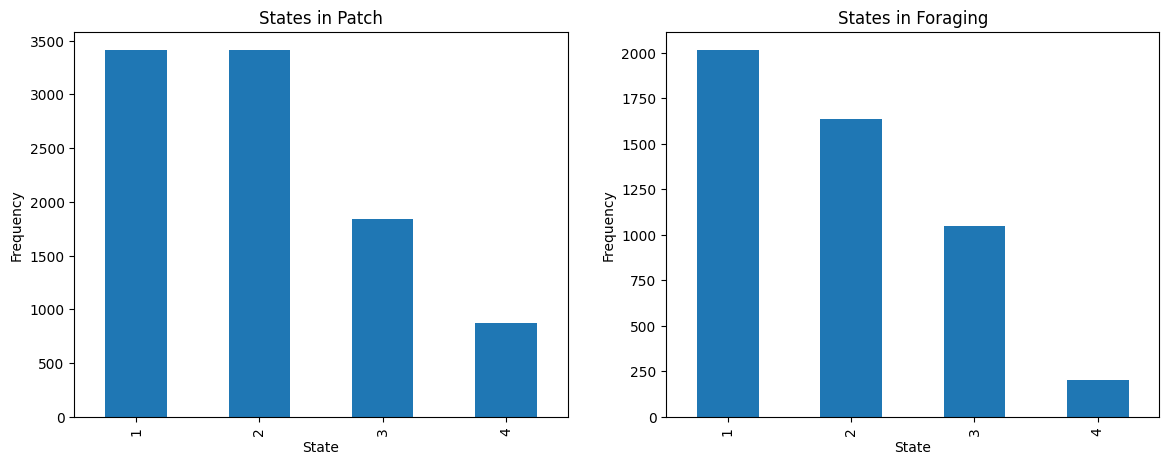

ShortSession1


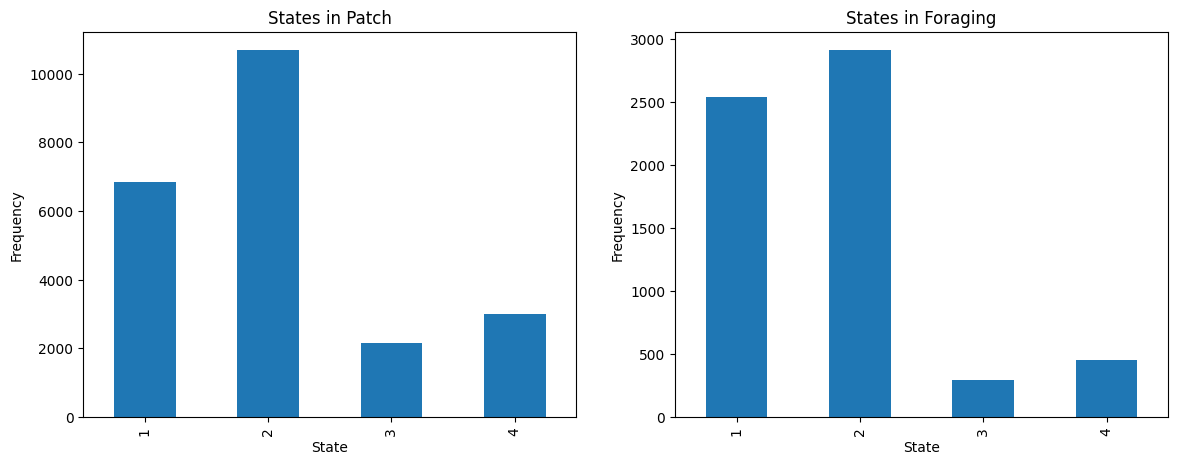

ShortSession2


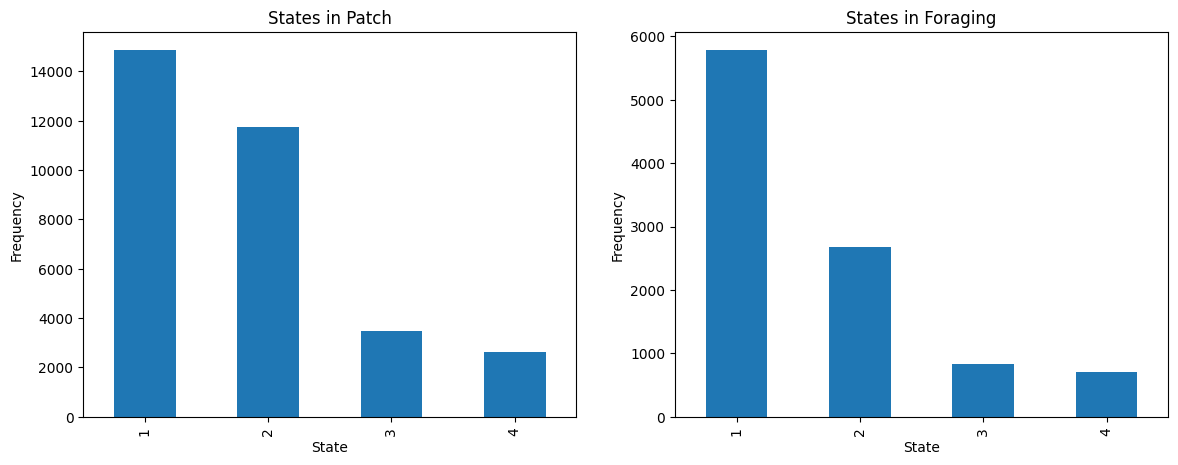

ShortSession3


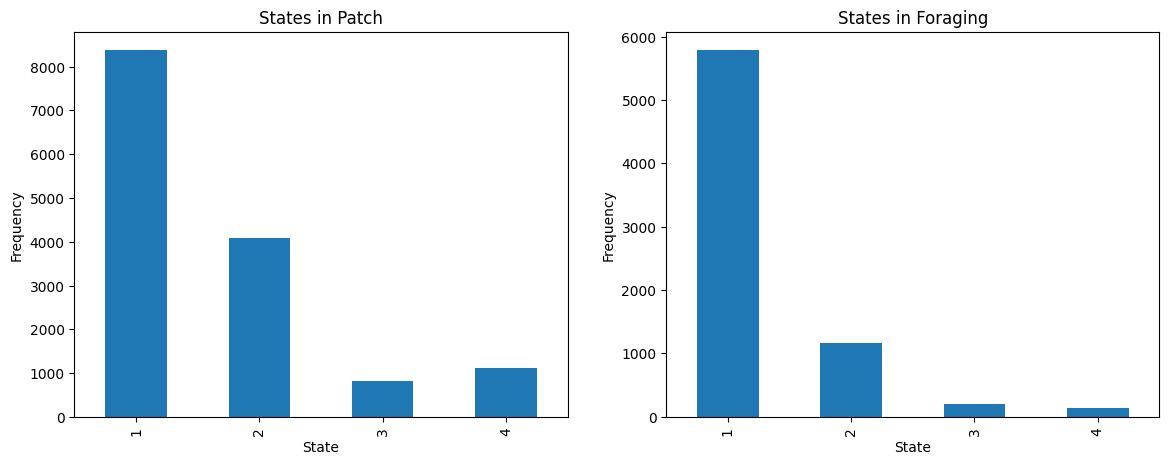

ShortSession4


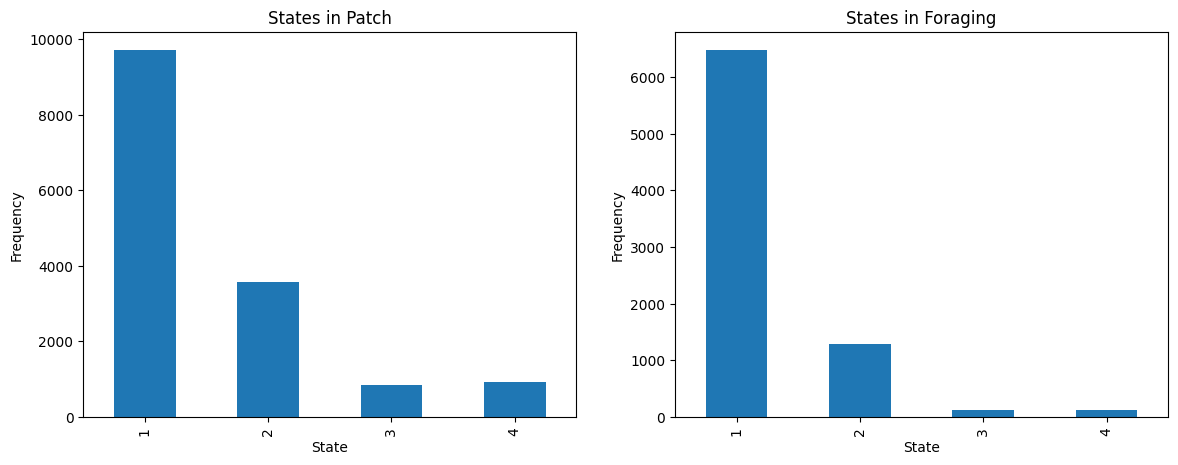

ShortSession5


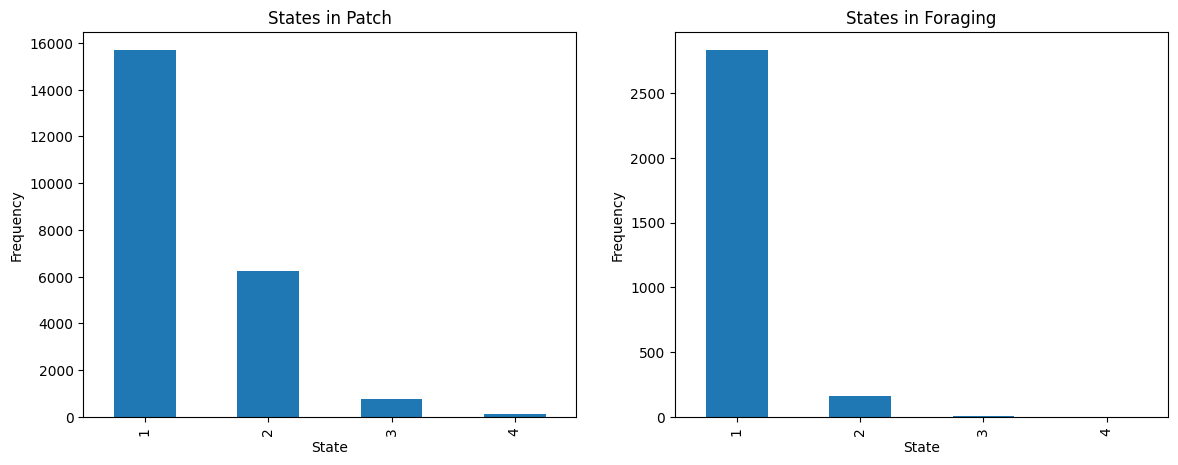

ShortSession6


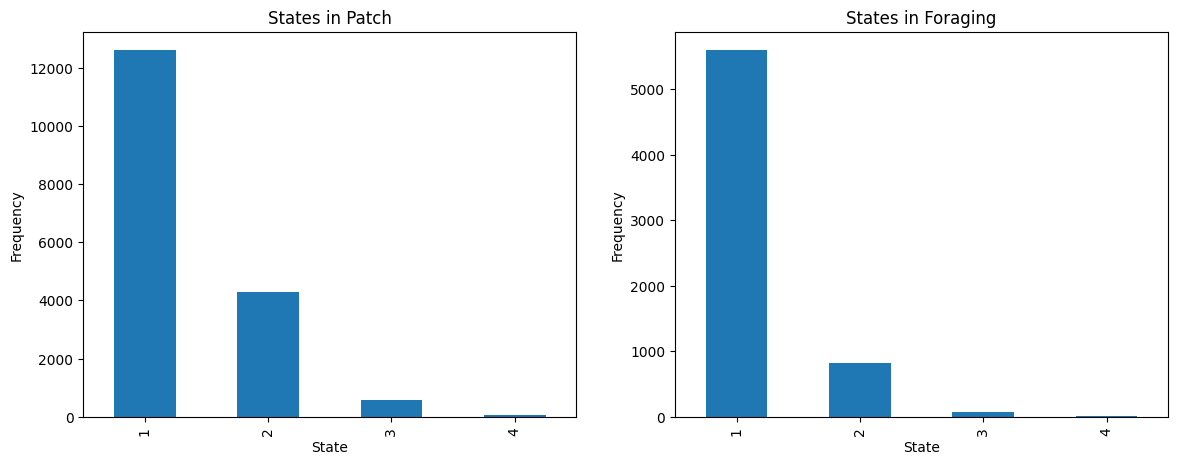

ShortSession7


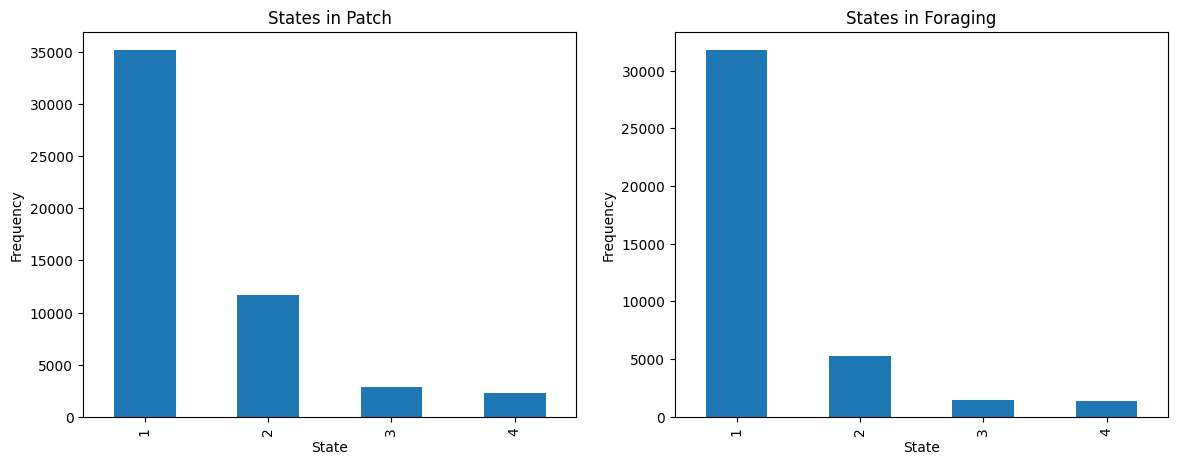

ShortSession8


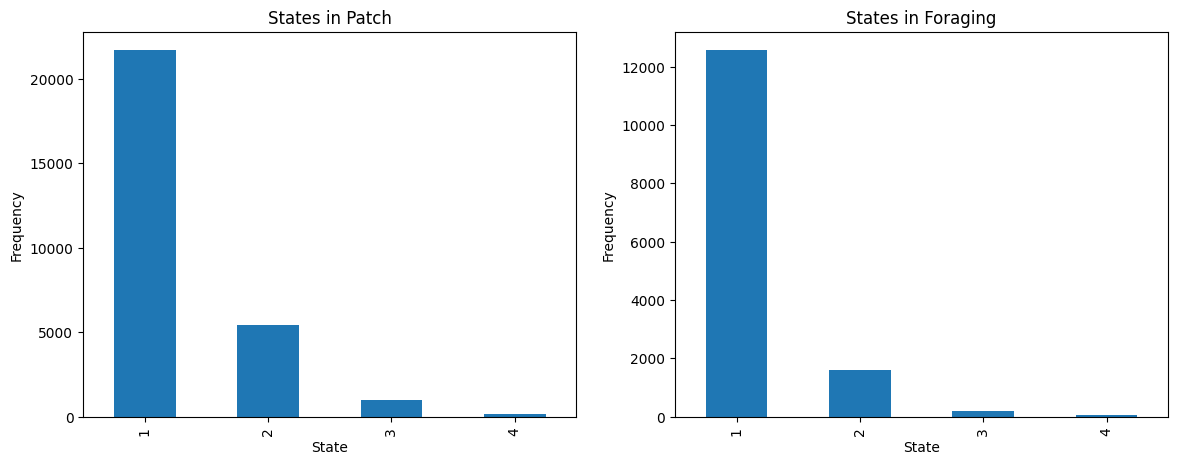

ShortSession9


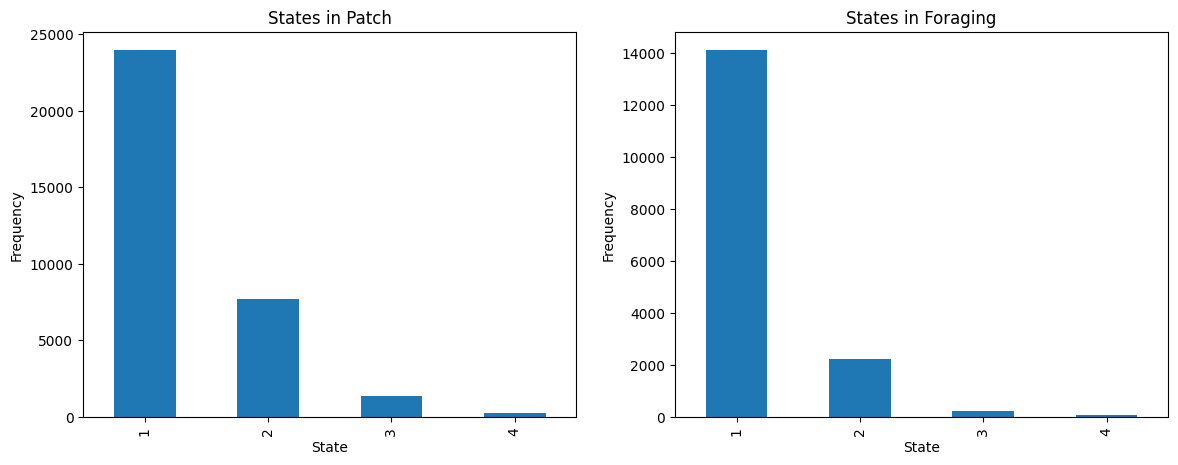

ShortSession10


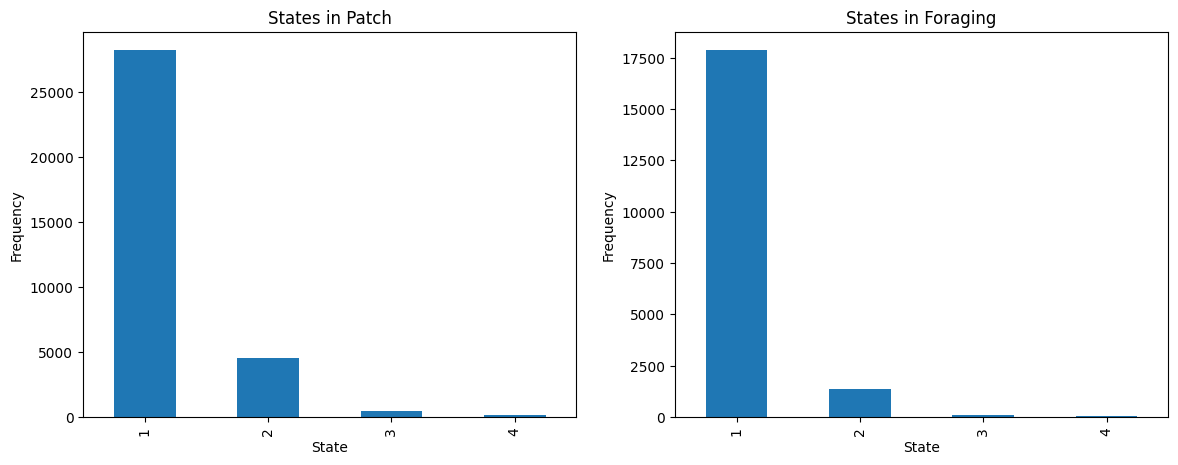

ShortSession11


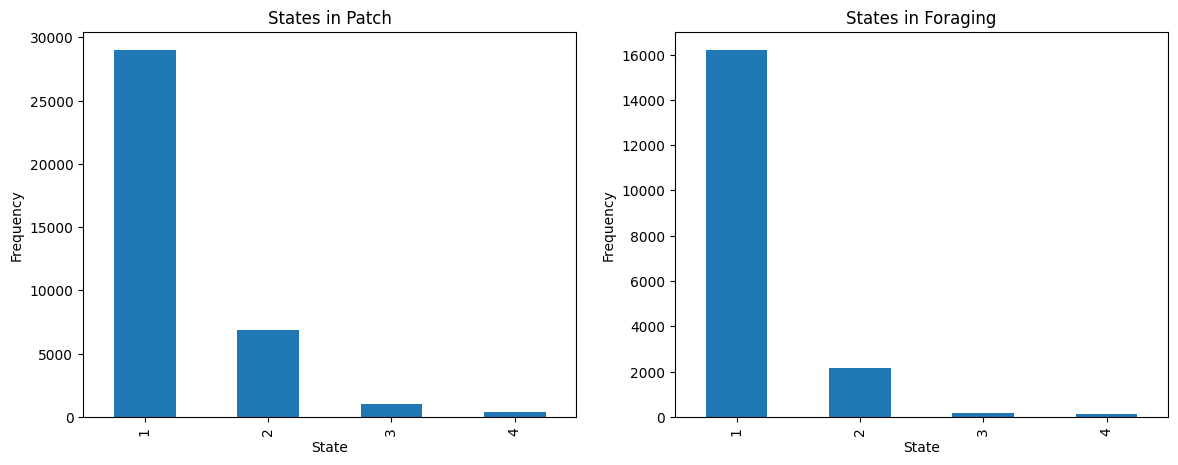

In [13]:
for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    #if j > 0: continue
    title = 'ShortSession'+str(j)
    print(title)
    
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
    mouse_pos = patch.DeleteRows(mouse_pos)
    start, end = mouse_pos.index[0], mouse_pos.index[-1]

    states = np.load(title+"States.npy", allow_pickle = True)
    mouse_pos['states'] = pd.Series(states, index=mouse_pos.index)
    
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
    
    
    fig, axs = plt.subplots(1,2,figsize = (14,5))
    
    inpatch = mouse_pos.loc[(mouse_pos['Patch1'] > 0) | (mouse_pos['Patch2'] > 0)] 
    state_frequency = inpatch['states'].value_counts()
    state_frequency = state_frequency.sort_index()

    state_frequency.plot(kind='bar', ax = axs[0])
    axs[0].set_xlabel('State')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('States in Patch')
    
    
    dfs = []
    for time in pd.to_datetime(pellets_patch1.index):
        start_time = time - pd.Timedelta(seconds=5)
        end_time = time + pd.Timedelta(seconds=5)
        dfs.append(mouse_pos.loc[start_time:end_time, :])
    for time in pd.to_datetime(pellets_patch2.index):
        start_time = time - pd.Timedelta(seconds=5)
        end_time = time + pd.Timedelta(seconds=5)
        dfs.append(mouse_pos.loc[start_time:end_time, :])

    forage = pd.concat(dfs, ignore_index=False)
    state_frequency = forage['states'].value_counts()
    state_frequency = state_frequency.sort_index()

    state_frequency.plot(kind='bar', ax = axs[1])
    axs[1].set_xlabel('State')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('States in Foraging')
    
    plt.show()